In [1]:
import os
from google.colab import files
uploaded = files.upload()  # Загрузите сюда свой kaggle.json
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

Saving kaggle.json to kaggle.json


In [2]:
# Скачиваем датасет
!kaggle datasets download mohammedmohsen0404/bone-fracture-dataset-good-data
#!kaggle datasets download pkdarabi/bone-fracture-detection-computer-vision-project

# Распаковываем датасет
!unzip -q bone-fracture-dataset-good-data.zip -d bone_fracture_dataset
#!unzip -q bone-fracture-detection-computer-vision-project.zip -d detection_data

# Удаляем zip-файл (по желанию)
!rm bone-fracture-dataset-good-data.zip
#!rm bone-fracture-detection-computer-vision-project.zip

Dataset URL: https://www.kaggle.com/datasets/mohammedmohsen0404/bone-fracture-dataset-good-data
License(s): apache-2.0


In [3]:
!mkdir -p merged_dataset/{train,valid,test}/{images,labels}

In [4]:
# Создаём файл конфигурации data.yaml
yaml_text = """
path: /content/merged_dataset
train: train
val: valid
test: test
names:
  0: fracture
"""

with open("merged_dataset/data.yaml", "w") as f:
  f.write(yaml_text)

In [5]:
import shutil
import glob

# Хелпер для переноса файлов
def merge_data(src_path, dst_path):
  for subset in ['train', 'valid', 'test']:
    for typ in ['images', 'labels']:
      src = os.path.join(src_path, subset, typ)
      dst = os.path.join(dst_path, subset, typ)
      if os.path.exists(src):
        for file in glob.glob(f"{src}/*"):
          shutil.copy(file, dst)

# Объединяем два датасета
merge_data("/content/bone_fracture_dataset", "merged_dataset")
merge_data("/content/detection_data/BoneFractureYolo8", "merged_dataset")

In [6]:
import shutil
import glob
import os

# Создаем папки, если их нет
for subset in ['train', 'valid', 'test']:
  for typ in ['images', 'labels']:
    os.makedirs(f"merged_dataset/{subset}/{typ}", exist_ok=True)

# Хелпер: копировать все файлы из src/* в dst/
def copy_all(src_folder, dst_folder):
  if os.path.exists(src_folder):
    for file in glob.glob(f"{src_folder}/*"):
      shutil.copy(file, dst_folder)

# Копируем из good_data
for subset in ['train', 'valid', 'test']:
  copy_all(f"good_data/{subset}/images", f"merged_dataset/{subset}/images")
  copy_all(f"good_data/{subset}/labels", f"merged_dataset/{subset}/labels")

# Копируем из detection_data
for subset in ['train', 'valid', 'test']:
  copy_all(f"detection_data/{subset}/images", f"merged_dataset/{subset}/images")
  copy_all(f"detection_data/{subset}/labels", f"merged_dataset/{subset}/labels")


In [ ]:
# Импорт и обучение модели
from ultralytics import YOLO

# Загружаем базовую модель
model = YOLO("yolov8m.pt")  # более точная модель (m вместо n)

# Обучаем модель
results = model.train(
    data="/content/merged_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0
)

# Оцениваем модель
model.val()

# Сохраняем модель
model.save("fracture_detector.pt")

# Скачать модель
from google.colab import files
files.download("fracture_detector.pt")

Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/merged_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning /content/merged_dataset/train/labels... 5161 images, 1827 backgrounds, 1498 corrupt: 100%|██████████| 5161/5161 [00:02<00:00, 2544.98it/s]

train: /content/merged_dataset/train/images/image1_0_png.rf.bc222874fa14e205b638e87ddad52b9d.jpg: ignoring corrupt image/label: Label class 5 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/merged_dataset/train/images/image1_0_png.rf.c864ea1d0d7a6ba347b3bd6fa51bf4c9.jpg: ignoring corrupt image/label: Label class 5 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/merged_dataset/train/images/image1_0_png.rf.d44c62635f246b717a95453d650ac2cb.jpg: ignoring corrupt image/label: Label class 5 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/merged_dataset/train/images/image1_1002_png.rf.1feafce607366113c97124dc22d52328.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/merged_dataset/train/images/image1_1002_png.rf.67c46c90c7089ef2ffa40b5fa22e4ad1.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible 

train: New cache created: /content/merged_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 186.2±79.9 MB/s, size: 10.5 KB)


val: Scanning /content/merged_dataset/valid/labels... 371 images, 175 backgrounds, 145 corrupt: 100%|██████████| 371/371 [00:00<00:00, 1444.93it/s]

val: /content/merged_dataset/valid/images/image1_0_png.rf.d29cab92b154a83ca5bf7e40083673a2.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/merged_dataset/valid/images/image1_1000_png.rf.7eebc2918f75be5baf4c32a091ef963d.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/merged_dataset/valid/images/image1_1049_png.rf.f5a123abb07f43506a840667ad755261.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/merged_dataset/valid/images/image1_104_png.rf.86a9d1eeedeec79216455a5b9be63e17.jpg: ignoring corrupt image/label: Label class 4 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/merged_dataset/valid/images/image1_1090_png.rf.de645f822a5e36175c5e988223f4eeb0.jpg: ignoring corrupt image/label: Label class 6 exceeds dataset class count 1. Possible class

Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       6.4G     0.9691        1.6      1.545         22        640:  39%|███▉      | 89/229 [00:49<01:17,  1.81it/s]


KeyboardInterrupt: 

In [ ]:
import os
for root, dirs, files in os.walk("/content/bone_fracture_dataset"):
    level = root.replace("/content/bone_fracture_dataset", "").count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:  # выводим первые 5 файлов каждой папки
        print(f"{subindent}{f}")


bone_fracture_dataset/
    data.yaml
    README.roboflow.txt
    README.dataset.txt
    valid/
        images/
            image1_309_png_jpg.rf.e68359b22045fe60a6dde48f3fed0645.jpg
            image1_765_png_jpg.rf.fa430729dbb43e2e8618db2f784be4d5.jpg
            image1_4993_png_jpg.rf.a0bd310ad4645b2c57bd999d6add4de6.jpg
            image1_401_png_jpg.rf.68b320a23ed582b1eb7b2b53a921a142.jpg
            image2_1540_png_jpg.rf.f1d5ca8a41ef8bae74ce5b682b38237a.jpg
        labels/
            image2_1540_png_jpg.rf.f1d5ca8a41ef8bae74ce5b682b38237a.txt
            image1_12_png_jpg.rf.72b8816a751b7b936cafaa83993965f3.txt
            image1_3167_png_jpg.rf.c9d6eb3db5fa5b389fdfa400cbad3a1f.txt
            elbow-dislocation-with-coronoid-process-fracture_jpg.rf.32ed67c41ce7f1006d0d4c6f3320144a.txt
            image1_8225_png_jpg.rf.70f8d1027bdd8539da57835d64d6e425.txt
    train/
        images/
            image1_3795_png_jpg.rf.979a57e1b82b93f7de7af322507545c9.jpg
            image1_1952_pn

In [ ]:
# Устанавливаем YOLOv8
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Создаем и обучаем модель (используем YOLOv8n для быстрого старта, затем можешь попробовать YOLOv8m или YOLOv8l для улучшения качества)
model = YOLO('yolov8n.pt')  # загружаем предварительно обученные веса на COCO

# Запускаем обучение
results = model.train(
    data='/content/bone_fracture_dataset/data.yaml',  # конфигурационный файл датасета YOLO (должен присутствовать)
    epochs=20,                                        # количество эпох обучения
    imgsz=640,                                        # размер изображений
    batch=16,                                         # размер пакета
    device=0                                          # использовать GPU
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 117MB/s]


Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/bone_fracture_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 20.8MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 86.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 69.1±66.3 MB/s, size: 11.3 KB)


train: Scanning /content/bone_fracture_dataset/train/labels... 1530 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1530/1530 [00:00<00:00, 1568.37it/s]

train: New cache created: /content/bone_fracture_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 32.2±61.4 MB/s, size: 11.8 KB)


val: Scanning /content/bone_fracture_dataset/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 333.89it/s]

val: New cache created: /content/bone_fracture_dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.1G     0.7971      1.395      1.432         33        640: 100%|██████████| 96/96 [00:32<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         23         23      0.757       0.95      0.898      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G     0.7736     0.8595      1.401         40        640: 100%|██████████| 96/96 [00:27<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         23         23      0.896      0.913      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.33G     0.7811     0.7661      1.403         32        640: 100%|██████████| 96/96 [00:27<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         23         23      0.994          1      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.35G     0.7494     0.7022      1.382         37        640: 100%|██████████| 96/96 [00:26<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         23         23      0.915          1      0.986      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.37G      0.712     0.6311      1.354         35        640: 100%|██████████| 96/96 [00:27<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         23         23      0.833      0.913      0.916      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.38G     0.7138     0.6112      1.353         33        640: 100%|██████████| 96/96 [00:26<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         23         23      0.996          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.4G     0.7114     0.6008      1.351         32        640: 100%|██████████| 96/96 [00:26<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         23         23      0.996          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.42G     0.6715     0.5504      1.323         33        640: 100%|██████████| 96/96 [00:27<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         23         23      0.909      0.957      0.887      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.43G     0.6748     0.5664      1.321         30        640: 100%|██████████| 96/96 [00:27<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         23         23      0.991          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.45G     0.6716     0.5623       1.32         29        640: 100%|██████████| 96/96 [00:26<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         23         23      0.953      0.874      0.962      0.916


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.47G      0.189     0.2552      1.028         10        640: 100%|██████████| 96/96 [00:26<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         23         23      0.998          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.48G      0.148     0.1493     0.9828         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.5G     0.1397     0.1325     0.9801         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         23         23      0.998          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.52G     0.1322     0.1219     0.9772         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.54G      0.123     0.1117     0.9732         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         23         23      0.998          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.55G     0.1202     0.1043     0.9686         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.57G     0.1153    0.09862     0.9632         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.59G     0.1072    0.09081     0.9612         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.61G     0.1049    0.08933     0.9508         10        640: 100%|██████████| 96/96 [00:23<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         23         23      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.62G     0.1008    0.08623     0.9562         10        640: 100%|██████████| 96/96 [00:24<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         23         23      0.998          1      0.995      0.995



20 epochs completed in 0.151 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.123 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


                   all         23         23      0.998          1      0.995      0.995
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


In [15]:
# Оценка на тестовом наборе
results = model.val()


Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


100%|██████████| 755k/755k [00:00<00:00, 22.2MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 60.9±110.4 MB/s, size: 21.4 KB)



val: Scanning /content/merged_dataset/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 1436.81it/s]

val: New cache created: /content/merged_dataset/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


                   all         23         23      0.998          1      0.995      0.992
Speed: 0.2ms preprocess, 27.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val


In [ ]:
import glob
from IPython.display import Image, display

# Выберем несколько изображений из тестовой выборки
test_images = glob.glob('/content/bone_fracture_dataset/test/images/*.jpg')[:5]

# Запускаем детекцию и отображаем результат
for img_path in test_images:
    result = model.predict(img_path, imgsz=640, conf=0.5)
    result_plotted = result[0].plot()
    display(Image(result_plotted))



image 1/1 /content/bone_fracture_dataset/test/images/image2_1196_png_jpg.rf.48d2cf7947617d3e17ac12278b308e7e.jpg: 640x640 1 fracture, 48.3ms
Speed: 10.0ms preprocess, 48.3ms inference, 14.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 /content/bone_fracture_dataset/test/images/image1_907_png_jpg.rf.bfc08d5c8c1a596f018b1fd69b50f8e4.jpg: 640x640 1 fracture, 54.6ms
Speed: 5.7ms preprocess, 54.6ms inference, 19.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 /content/bone_fracture_dataset/test/images/image1_4209_png_jpg.rf.8a05ad567ef63d85583e389ece6fab17.jpg: 640x640 1 fracture, 27.1ms
Speed: 2.6ms preprocess, 27.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 /content/bone_fracture_dataset/test/images/image1_123_png_jpg.rf.82430fb6d30c633721051243d4701e23.jpg: 640x640 1 fracture, 56.6ms
Speed: 23.6ms preprocess, 56.6ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 /content/bone_fracture_dataset/test/images/image1_4007_png_jpg.rf.3eb744559fec410a327e302c7f0e41de.jpg: 640x640 1 fracture, 51.1ms
Speed: 11.7ms preprocess, 51.1ms inference, 14.2ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
from IPython.display import Image, display
import glob

# Путь к изображениям с результатами
results_images = glob.glob('runs/detect/train2/*.jpg')

# Показываем первые несколько изображений
for img_path in results_images[:5]:
    display(Image(img_path))


🖼️ Оригинальное изображение:


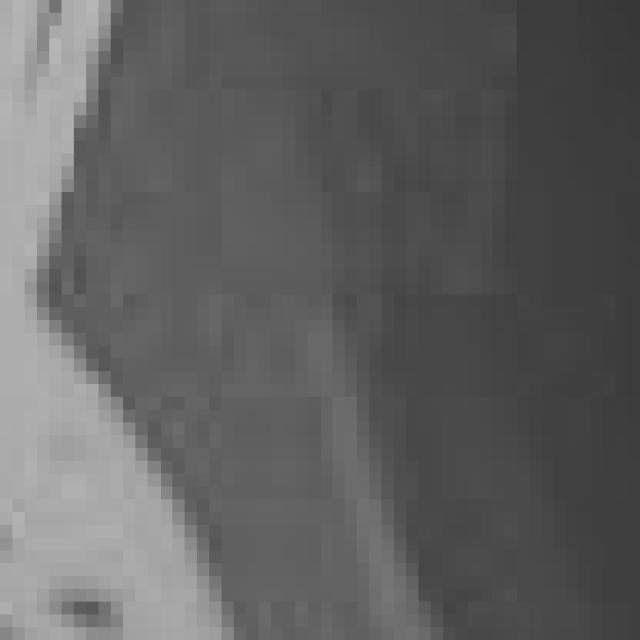

📌 Оригинальный диагноз: Перелом есть ✅ (объектов: 1)

image 1/1 /content/bone_fracture_dataset/valid/images/image1_408_png_jpg.rf.a909960d28d1e294035033bb46679eb8.jpg: 640x640 1 fracture, 37.2ms
Speed: 3.3ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
🤖 Диагноз от модели: Перелом обнаружен ✅
🧠 Предсказание модели, наложенное на оригинал:


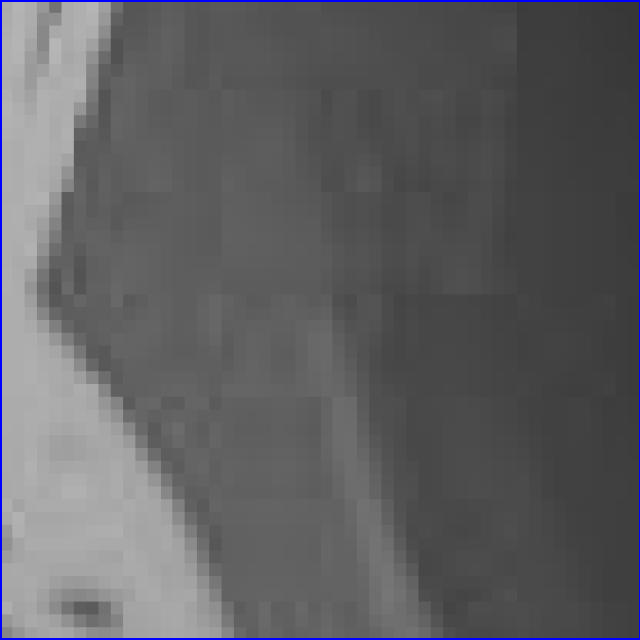

In [24]:
import random
import glob
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image as PILImage
from IPython.display import display

# Загружаем модель
#model = YOLO('runs/detect/train2/weights/best.pt')

# Получаем путь к изображениям и меткам
image_paths = glob.glob('/content/bone_fracture_dataset/valid/images/*.jpg')
label_paths = glob.glob('/content/bone_fracture_dataset/valid/labels/*.txt')

# Выбираем случайное изображение
random_idx = random.randint(0, len(image_paths) - 1)
img_path = image_paths[random_idx]
label_path = label_paths[random_idx]

# Загружаем оригинальное изображение (в хорошем качестве)
original_img = cv2.imread(img_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_pil = PILImage.fromarray(original_img_rgb)

# Показываем оригинал
print("🖼️ Оригинальное изображение:")
display(original_pil)

# Читаем разметку
with open(label_path, 'r') as f:
    labels = [line.strip() for line in f if line.strip()]

if labels:
    original_diag = f"Перелом есть ✅ (объектов: {len(labels)})"
else:
    original_diag = "Перелома нет ❌"

print(f"📌 Оригинальный диагноз: {original_diag}")

# Прогоняем изображение через модель
results = model.predict(source=img_path, imgsz=640, conf=0.5)[0]

# Анализируем результат
if len(results.boxes) > 0:
    print("🤖 Диагноз от модели: Перелом обнаружен ✅")
else:
    print("🤖 Диагноз от модели: Перелом не обнаружен ❌")

# Получаем координаты боксов в масштабе оригинала
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    label = f"{model.names[cls_id]} {conf:.2f}"
    cv2.rectangle(original_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(original_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255, 0, 0), 2)

# Преобразуем и покажем изображение с результатом поверх оригинала
result_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
result_pil = PILImage.fromarray(result_img_rgb)

print("🧠 Предсказание модели, наложенное на оригинал:")
display(result_pil)


🧠 Результат анализа модели:


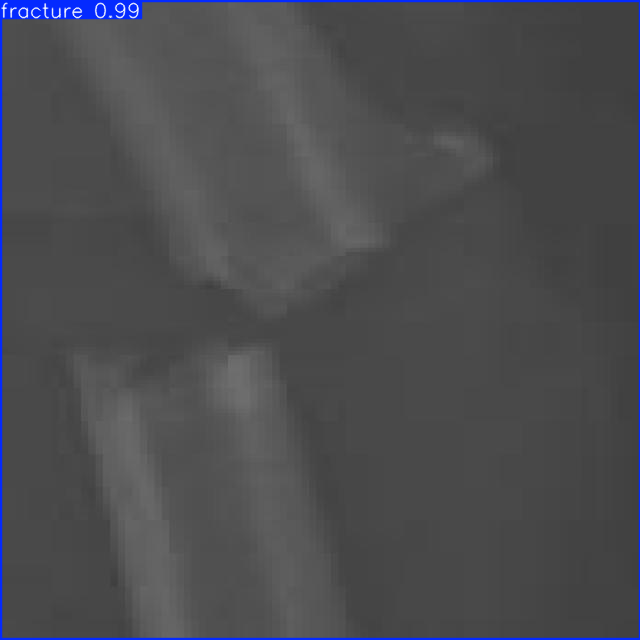

In [19]:
import IPython.display as display
from PIL import Image as PILImage

# Показываем изображение от модели (результат с обводкой)
result_img_array = results[0].plot()  # это numpy array в формате BGR

# Преобразуем в RGB и делаем нормальную PIL-картинку
result_img_rgb = cv2.cvtColor(result_img_array, cv2.COLOR_BGR2RGB)
result_pil = PILImage.fromarray(result_img_rgb)

# Отображаем с высоким качеством
print("🧠 Результат анализа модели:")
display.display(result_pil)


In [10]:
!pip install ultralytics

In [8]:
ls

bone_fracture_dataset/  merged_dataset/  sample_data/


In [12]:
from google.colab import files
from ultralytics import YOLO

uploaded = files.upload()
model_path = list(uploaded.keys())[0]
model = YOLO(model_path)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving fracture_detector (1).pt to fracture_detector (1) (2).pt


Saving 12.png to 12.png
🖼️ Оригинальное изображение:


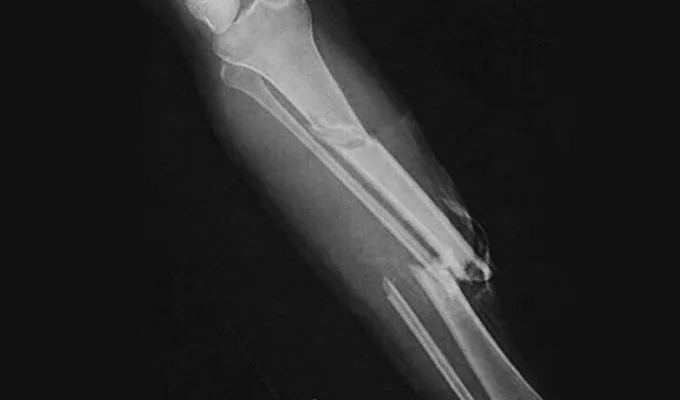


image 1/1 /content/12.png: 384x640 (no detections), 48.6ms
Speed: 4.0ms preprocess, 48.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
🤖 Диагноз от модели: Перелом не обнаружен ❌
📊 Предсказание модели, наложенное на оригинал:


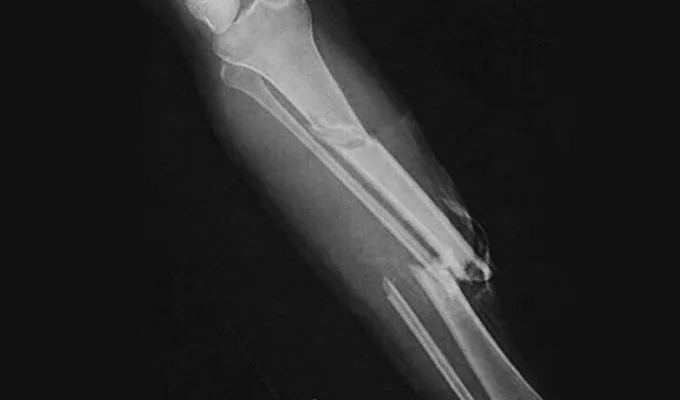

In [14]:
import cv2
import numpy as np
from PIL import Image as PILImage
from IPython.display import display
from google.colab import files
from ultralytics import YOLO

# ⬆️ 1. Загружаем картинку
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # берём имя загруженного файла


# 📷 3. Читаем и показываем оригинальное изображение
original_img = cv2.imread(img_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_pil = PILImage.fromarray(original_img_rgb)

print("🖼️ Оригинальное изображение:")
display(original_pil)

# 🧠 4. Прогоняем через модель
results = model.predict(source=img_path, imgsz=640, conf=0.5)[0]

# 📌 5. Выводим диагноз
if len(results.boxes) > 0:
    print(f"🤖 Диагноз от модели: Перелом обнаружен ✅ (объектов: {len(results.boxes)})")
else:
    print("🤖 Диагноз от модели: Перелом не обнаружен ❌")

# 🧾 6. Накладываем предсказания на оригинальное изображение
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    label = f"{model.names[cls_id]} {conf:.2f}"
    cv2.rectangle(original_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(original_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255, 0, 0), 2)

# 🖼️ 7. Показываем результат
result_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
result_pil = PILImage.fromarray(result_img_rgb)

print("📊 Предсказание модели, наложенное на оригинал:")
display(result_pil)


In [25]:
import cv2
import numpy as np
from PIL import Image as PILImage
from IPython.display import display
from google.colab import files
from ultralytics import YOLO

# 🔽 Загрузка изображения
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# 🔧 Обрезаем центр изображения
def crop_center(image, cropx=512, cropy=512):
    y, x, _ = image.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return image[starty:starty + cropy, startx:startx + cropx]

# 📥 Читаем оригинал и обрезаем центр
original_img = cv2.imread(img_path)
cropped_img = crop_center(original_img)

# Сохраняем cropped-изображение временно
cv2.imwrite("cropped_input.jpg", cropped_img)

# 🎯 Загружаем обученную модель
#model = YOLO("runs/detect/train2/weights/best.pt")

# 🔍 Прогоняем через модель
results = model.predict("cropped_input.jpg", imgsz=640, conf=0.5)[0]

# 📌 Выводим диагноз
if len(results.boxes) > 0:
    print(f"🤖 Диагноз: Перелом обнаружен ✅ (объектов: {len(results.boxes)})")
else:
    print("🤖 Диагноз: Перелом не обнаружен ❌")

# 🖼️ Отображаем результат
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    label = f"{model.names[cls_id]} {conf:.2f}"
    cv2.rectangle(cropped_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(cropped_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (255, 0, 0), 2)

# Преобразуем и показываем
result_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
result_pil = PILImage.fromarray_


Saving 12.png to 12 (1).png

image 1/1 /content/cropped_input.jpg: 96x640 (no detections), 101.2ms
Speed: 1.2ms preprocess, 101.2ms inference, 0.8ms postprocess per image at shape (1, 3, 96, 640)
🤖 Диагноз: Перелом не обнаружен ❌


AttributeError: module 'PIL.Image' has no attribute 'fromarray_'